In [89]:
import pandas as pd
import re 
import json
from collections import Counter
import matplotlib.pyplot as plt
import datetime

SECTOR = "IT"

def clean_text(text):
    # remove multiple newlines
    text = re.sub(r'\n+', '\n', text)
    # remove multiple spaces
    text = re.sub(r' +', ' ', text)
    # strip leading and trailing whitespace
    text = text.strip()
    # remove triple backticks and the word markdown
    text = text.replace("```", "").replace("markdown", "")
    # remove first and last newlines
    text = text.lstrip('\n').rstrip('\n')
    return text

def parse_markdown_json(md_json: str):
    """Parse a markdown-formatted JSON string (with ```json ... ``` markers)."""
    # Remove the markdown code block markers
    cleaned = md_json.strip()
    if cleaned.startswith("```json"):
        cleaned = cleaned[len("```json"):].strip()
    if cleaned.endswith("```"):
        cleaned = cleaned[:-3].strip()
    return json.loads(cleaned)



df = pd.read_csv(f"data/processed/{SECTOR.lower()}_resumes.csv")
df.drop(columns=['resume', 'anonymized', 'reformatted'], inplace=True)
df.rename(columns={'localized': 'resume'}, inplace=True)
df['resume'] = df['resume'].apply(clean_text)
df.head(5)

,Category,resume
0,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY\n*...
1,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SP...
2,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SU...
3,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY IN...
4,INFORMATION-TECHNOLOGY,[Candidate Name] \n**INFORMATION TECHNOLOGY MA...


Counter({'NUS': 164, 'SP': 122, 'RP': 59, 'NTU': 48, 'SMU': 43, 'TP': 40, 'SIT': 21, 'RI': 15, 'SUS': 9, 'NYP': 8, 'NP': 4, 'SUTD': 0, 'INSEAD': 0, 'ESSEC': 0, 'RJC': 0, 'HCI': 0, 'ACJC': 0, 'ACSI': 0, 'DHS': 0, 'MGS': 0})


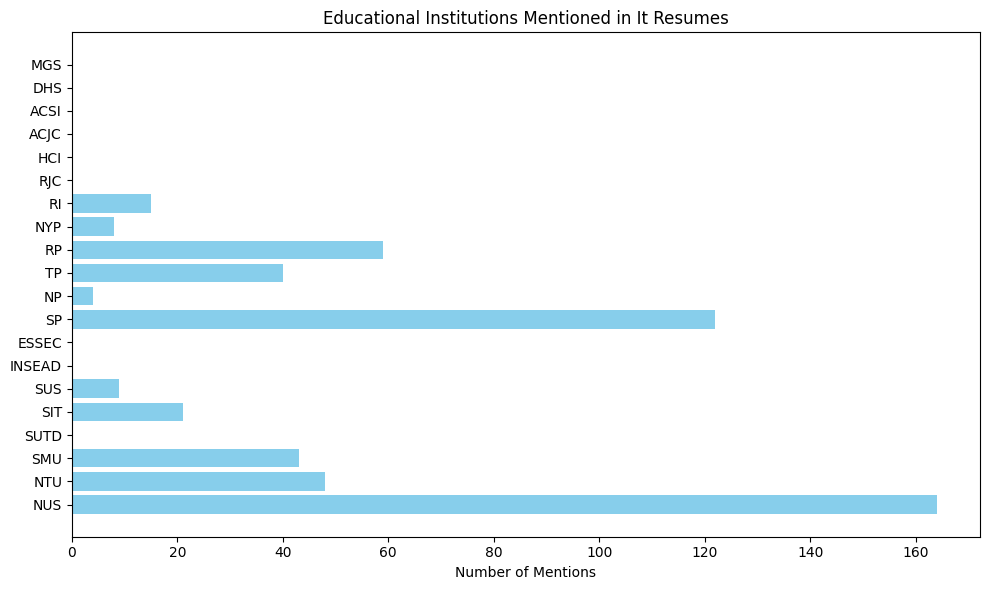

In [90]:
identical = {
    "NUS": ["National University of Singapore", "National University of Singapore Singapore", "NUS Singapore", "NUS University", "NUS University Singapore"],
    "NTU": ["Nanyang Technological University", "Nanyang Technological University Singapore", "NTU Singapore", "NTU University", "NTU University Singapore"],
    "SMU": ["Singapore Management University", "Singapore Management University Singapore", "SMU Singapore", "SMU University", "SMU University Singapore"],
    "SUTD": ["Singapore University of Technology and Design", "Singapore University of Technology and Design Singapore", "SUTD Singapore", "SUTD University", "SUTD University Singapore"],
    "SIT": ["Singapore Institute of Technology", "Singapore Institute of Technology Singapore", "SIT Singapore", "SIT University", "SIT University Singapore"],
    "SUS": ["Singapore University of Social Sciences", "Singapore University of Social Sciences Singapore", "SUSS Singapore", "SUSS University", "SUSS University Singapore"],
    "INSEAD": ["INSEAD Business School", "INSEAD Business School Singapore", "INSEAD Singapore", "INSEAD University", "INSEAD University Singapore"],
    "ESSEC": ["ESSEC Business School", "ESSEC Business School Singapore", "ESSEC Singapore", "ESSEC University", "ESSEC University Singapore"],
    "SP": ["Singapore Polytechnic", "Singapore Polytechnic Singapore", "SP Singapore", "SP University", "SP University Singapore"],
    "NP": ["Ngee Ann Polytechnic", "Ngee Ann Polytechnic Singapore", "NP Singapore", "NP University", "NP University Singapore"],
    "TP": ["Temasek Polytechnic", "Temasek Polytechnic Singapore", "TP Singapore", "TP University", "TP University Singapore"],
    "RP": ["Republic Polytechnic", "Republic Polytechnic Singapore", "RP Singapore", "RP University", "RP University Singapore"],
    "NYP": ["Nanyang Polytechnic", "Nanyang Polytechnic Singapore", "NYP Singapore", "NYP University", "NYP University Singapore"],
    "RI": ["Raffles Institution", "Raffles Institution Singapore", "RI Singapore", "RI School", "RI School Singapore"],
    "RJC": ["Raffles Junior College", "Raffles Junior College Singapore", "RJC Singapore", "RJC School", "RJC School Singapore"],
    "HCI": ["Hwa Chong Institution", "Hwa Chong Institution Singapore", "HCI Singapore", "HCI School", "HCI School Singapore"],
    "ACJC": ["Anglo-Chinese Junior College", "Anglo-Chinese Junior College Singapore", "ACJC Singapore", "ACJC School", "ACJC School Singapore"],
    "ACSI": ["Anglo-Chinese School (Independent)", "Anglo-Chinese School (Independent) Singapore", "ACSI Singapore", "ACSI School", "ACSI School Singapore"],
    "DHS": ["Dunman High School", "Dunman High School Singapore", "DHS Singapore", "DHS School", "DHS School Singapore"],
    "MGS": ["Methodist Girls' School", "Methodist Girls' School Singapore", "MGS Singapore", "MGS School", "MGS School Singapore"]

}
counts = Counter()
# find all counts of identical keys in each resume
for i, row in df.iterrows():
    for key in identical.keys():
        for variant in identical[key]:
            counts[key] += row['resume'].count(variant)
        counts[key] += row['resume'].count(key)
print(counts)


# Only p]lot the educational institutions in identical.keys()
plt.figure(figsize=(10, 6))
plt.barh([key for key in counts.keys() if key in identical], [counts[key] for key in counts.keys() if key in identical], color='skyblue')
plt.xlabel('Number of Mentions')
plt.title(f'Educational Institutions Mentioned in {SECTOR.title()} Resumes')
plt.tight_layout()
plt.savefig(f"analysis/educational_institutions_{SECTOR.lower()}.png")
plt.show()

In [91]:
from src.utils.pipeline_utils import batch_job_analysis_pipeline

processed_resumes = batch_job_analysis_pipeline(df['resume'])

print(len(processed_resumes), processed_resumes[0])

120 {'resume_id': 0, 'work_experience': '```json\n[\n    {\n        "company": "ST Engineering",\n        "position": "Information Technology",\n        "start_date": "2011-02",\n        "end_date": "Present"\n    },\n    {\n        "company": "DBS Bank",\n        "position": "Systems Engineer",\n        "start_date": "2006-02",\n        "end_date": "2011-02"\n    },\n    {\n        "company": "SingTel",\n        "position": "Senior Systems Analyst",\n        "start_date": "1999-02",\n        "end_date": "2006-02"\n    }\n]\n```'}


In [92]:

# add to the dataframe

if 'job_history' not in df.columns:
    df['job_history'] = [None] * len(df)
if 'years_experience' not in df.columns:
    df['years_experience'] = [None] * len(df)

for id in processed_resumes:
    key = processed_resumes[id]['resume_id']
    try:
        df.at[key, 'job_history'] = json.dumps(parse_markdown_json(processed_resumes[id]['work_experience']))
    except:
        print(f"Error parsing work_experience for resume_id {key}")
        print(processed_resumes[id]['work_experience'])
        raise ValueError("Error parsing work_experience")
    # calculate total years of experience
    total = 0
    for job in parse_markdown_json(processed_resumes[id]['work_experience']):
        # subtract end date - start date
        # start and end date are in the format "YYYY-MM"
        try:
            start_date = datetime.datetime.strptime(job['start_date'], "%Y-%m")
            if job['end_date'].lower() in ['present', 'current']:
                end_date = datetime.datetime.now()
            else:
                end_date = datetime.datetime.strptime(job['end_date'], "%Y-%m")
            total += round((end_date - start_date).days / 365.25)
        except:
            pass
    df.at[key, 'years_experience'] = total

df.head()

,Category,resume,job_history,years_experience
0,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY\n*...,"[{""company"": ""ST Engineering"", ""position"": ""In...",27
1,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SP...,"[{""company"": ""ST Engineering"", ""position"": ""In...",50
2,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SU...,"[{""company"": ""ST Engineering"", ""position"": ""In...",9
3,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY IN...,"[{""company"": ""Singapore Institute of Technolog...",24
4,INFORMATION-TECHNOLOGY,[Candidate Name] \n**INFORMATION TECHNOLOGY MA...,"[{""company"": ""National University of Singapore...",26


In [93]:
# calculate most common job titles
companies = Counter()
positions = Counter()
years_experience = []
for i, row in df.iterrows():
    if row['job_history']:
        try:
            jobs = json.loads(row['job_history'])
            for job in jobs:
                company = job.get('company', None)
                position = job.get('position', None)
                if company:
                    companies[company] += 1
                if position:
                    positions[position] += 1
        except:
            pass
    if row['years_experience']:
        years_experience.append(row['years_experience'])

# Combine SingTel and Singtel
if 'Singtel' in companies and 'SingTel' in companies:
    companies['Singtel'] += companies['SingTel']
    del companies['SingTel']

# Combine SATS Ltd and SATS Ltd.
if 'SATS Ltd' in companies and 'SATS Ltd.' in companies:
    companies['SATS Ltd'] += companies['SATS Ltd.']
    del companies['SATS Ltd.']

# Combine National University of Singapore and NUS (National University of Singapore)
if 'National University of Singapore' in companies and 'NUS (National University of Singapore)' in companies:
    companies['National University of Singapore'] += companies['NUS (National University of Singapore)']
    del companies['NUS (National University of Singapore)']

sum(companies.values())

481

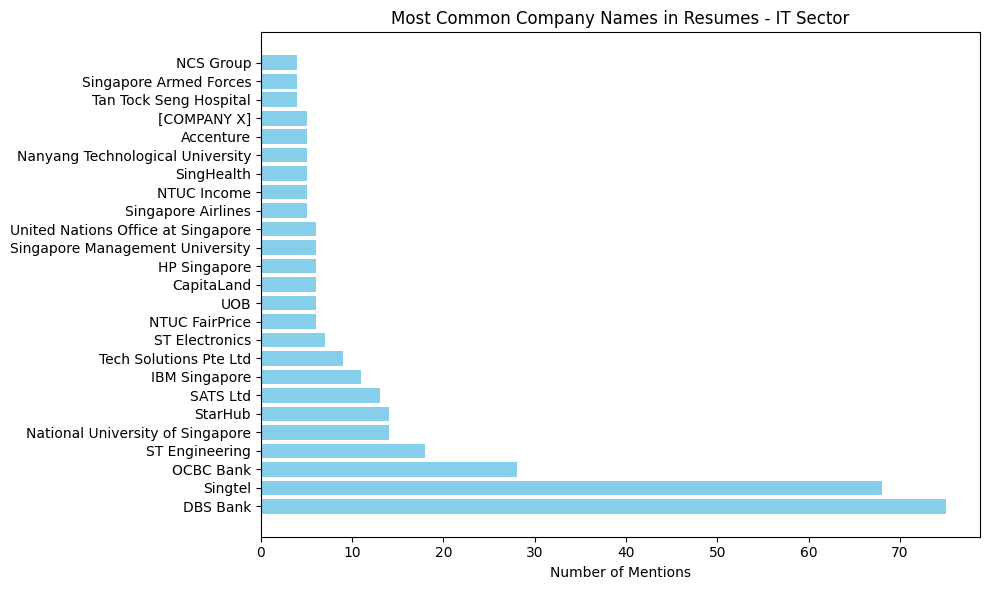

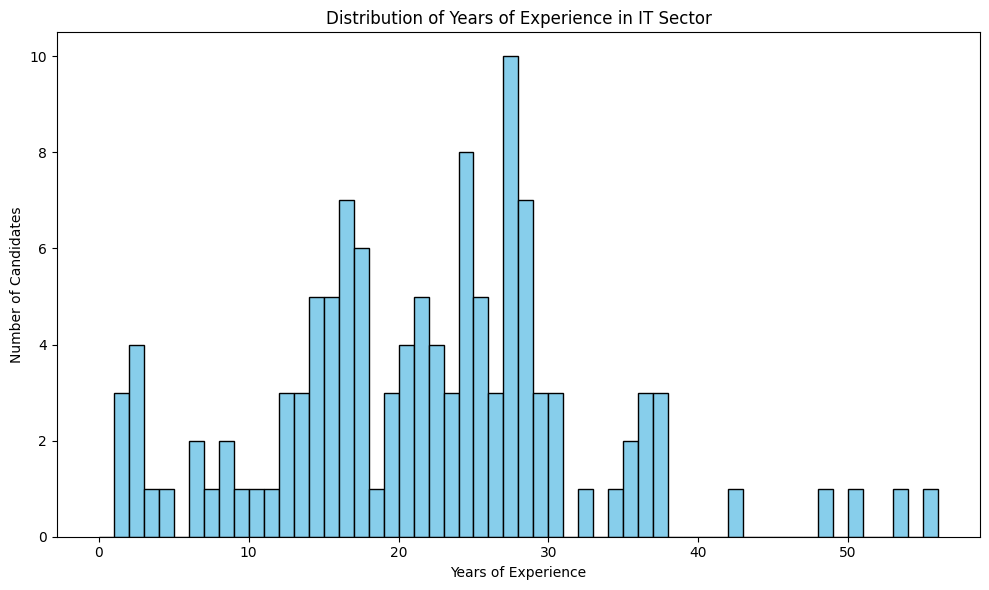

In [94]:
from pathlib import Path
Path("analysis").mkdir(parents=True, exist_ok=True)

# Save figures in analysis folder
plt.figure(figsize=(10, 6))
most_common_companies = companies.most_common(25)
plt.barh([company for company, count in most_common_companies], [count for company, count in most_common_companies], color='skyblue')
plt.xlabel('Number of Mentions')
plt.title(f'Most Common Company Names in Resumes - {SECTOR} Sector')
plt.tight_layout()
plt.savefig(f"analysis/most_common_companies_{SECTOR.lower()}.png")
plt.figure(figsize=(10, 6))
plt.hist(years_experience, bins=range(0, max(years_experience)+2, 1), color='skyblue', edgecolor='black')
plt.xlabel('Years of Experience')
plt.ylabel('Number of Candidates')
plt.title(f'Distribution of Years of Experience in {SECTOR} Sector')
plt.tight_layout()
plt.savefig(f"analysis/years_experience_distribution_{SECTOR.lower()}.png")

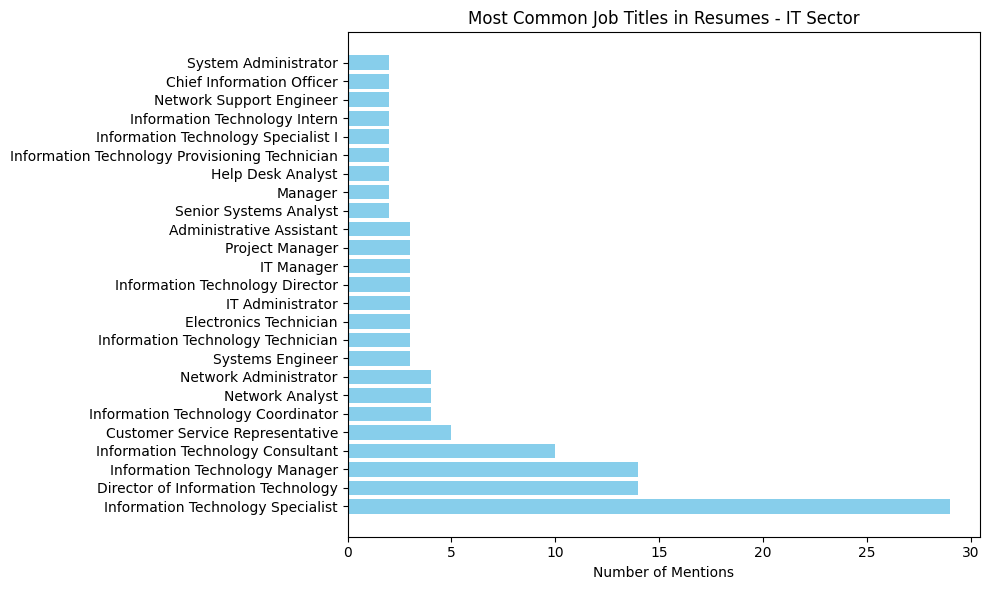

In [95]:
plt.figure(figsize=(10, 6))
most_common_positions = positions.most_common(25)
plt.barh([position for position, count in most_common_positions], [count for position, count in most_common_positions], color='skyblue')
plt.xlabel('Number of Mentions')
plt.title(f'Most Common Job Titles in Resumes - {SECTOR} Sector')
plt.tight_layout()
plt.savefig(f"analysis/most_common_positions_{SECTOR.lower()}.png")
plt.show()

In [96]:
from src.utils.pipeline_utils import batch_race_analysis_pipeline

results = batch_race_analysis_pipeline(df['resume'])
print(len(results))

# add name and ethnicity to the dataframe
df['name'] = df.index.map(lambda idx: results[idx]['name'] if idx in results else None)
df['ethnicity'] = df.index.map(lambda idx: results[idx]['ethnicity'] if idx in results else None)

df.head()

120


,Category,resume,job_history,years_experience,name,ethnicity
0,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY\n*...,"[{""company"": ""ST Engineering"", ""position"": ""In...",27,David Tan,Chinese
1,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SP...,"[{""company"": ""ST Engineering"", ""position"": ""In...",50,Ethan Tan,Chinese
2,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY SU...,"[{""company"": ""ST Engineering"", ""position"": ""In...",9,Ethan Tan,Chinese
3,INFORMATION-TECHNOLOGY,[Candidate Name]\n## INFORMATION TECHNOLOGY IN...,"[{""company"": ""Singapore Institute of Technolog...",24,Aidan Tan,Chinese
4,INFORMATION-TECHNOLOGY,[Candidate Name] \n**INFORMATION TECHNOLOGY MA...,"[{""company"": ""National University of Singapore...",26,Ethan Tan,Chinese


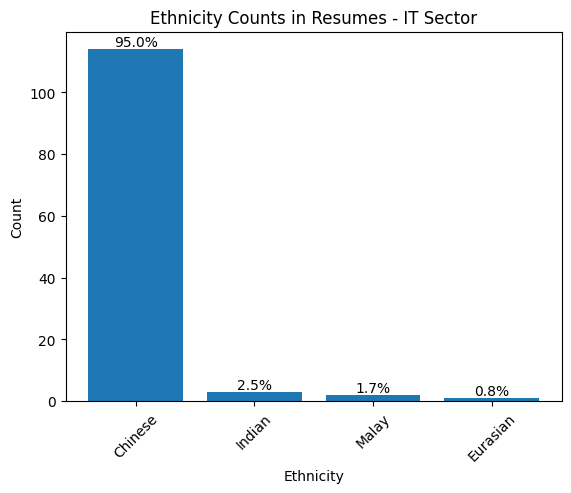

In [101]:
# plot a bar chart of ethnicity counts
import matplotlib.pyplot as plt

ethnicity_counts = df['ethnicity'].value_counts()
plt.bar(ethnicity_counts.index, ethnicity_counts.values)
plt.xlabel('Ethnicity')
plt.ylabel('Count')
# Add percentages on top of bars
total = sum(ethnicity_counts.values)
for i, v in enumerate(ethnicity_counts.values):
    plt.text(i, v + 1, f"{v/total:.1%}", ha='center')
plt.title(f'Ethnicity Counts in Resumes - {SECTOR} Sector')
plt.xticks(rotation=45)
plt.savefig(f"analysis/ethnicity_counts_{SECTOR.lower()}.png")
plt.show()

In [98]:
# Save the dataframe to a csv file
df.to_csv(f"data/processed/{SECTOR.lower()}_resumes_detailed.csv", index=False)

In [99]:
df.tail()

,Category,resume,job_history,years_experience,name,ethnicity
115,INFORMATION-TECHNOLOGY,[Candidate Name]\n## CORPORATE PROJECT MANAGER...,"[{""company"": ""DBS Bank"", ""position"": ""Corporat...",10,Ethan Tan,Chinese
116,INFORMATION-TECHNOLOGY,## [Candidate Name]\n**IT TECHNOLOGY SPECIALIS...,"[{""company"": ""DBS Bank"", ""position"": ""IT Techn...",8,Ethan Tan,Chinese
117,INFORMATION-TECHNOLOGY,[Candidate Name]\n## IT MANAGER\n**Highlights*...,"[{""company"": ""Singtel"", ""position"": ""IT Manage...",25,Rajesh Kumar,Indian
118,INFORMATION-TECHNOLOGY,[Candidate Name]\n## Subject Matter Expert (In...,"[{""company"": ""United Nations Office at Singapo...",24,Aiden Tan,Chinese
119,INFORMATION-TECHNOLOGY,## [Candidate Name]\n**TRAINING MANAGER**\n**E...,"[{""company"": ""SATS Ltd."", ""position"": ""Trainin...",13,Ethan Tan,Chinese


In [100]:
# count the number of unique names
print(f"Number of unique names: {df['name'].nunique()}")

# count the number of Tan's 
print(f"Number of Tan's: {df['name'].str.contains('Tan', na=False).sum()}")

Number of unique names: 23
Number of Tan's: 114


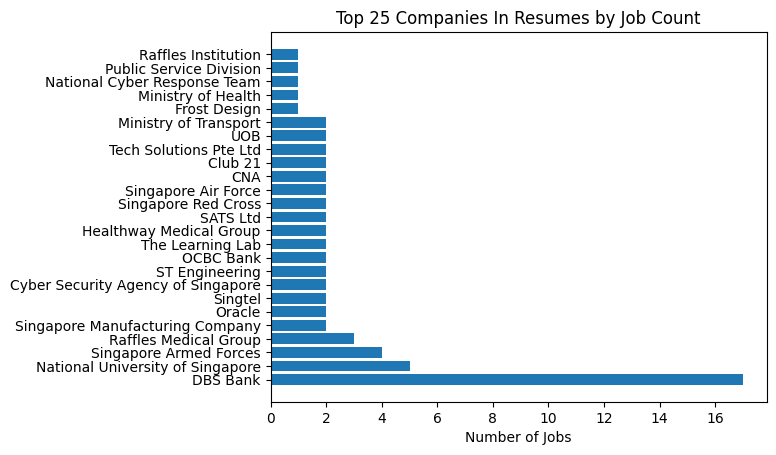

In [ ]:
# # plot the top 20 companies
# aggregated_data_sample = {
#  'Singapore Manufacturing Company': 2,
#  'Oracle': 2,
#  'Singtel': 2,
#  'DBS Bank': 17,
#  'Frost Design': 1,
#  'Singapore Armed Forces': 4,
#  'Ministry of Health': 1,
#  'Cyber Security Agency of Singapore': 2,
#  'National Cyber Response Team': 1,
#  'Public Service Division': 1,
#  'ST Engineering': 2,
#  'OCBC Bank': 8,
#  'Raffles Institution': 1,
#  'Little Skool-House International': 1,
#  'McDonald’s Singapore': 1,
#  'The Learning Lab': 2,
#  'Healthway Medical Group': 2,
#  'Home Nursing Foundation': 1,
#  'SATS Ltd': 2,
#  'Charles & Keith': 1,
#  'Metro Holdings': 1,
#  'H&M': 1,
#  'Takashimaya': 1,
#  'Raffles Medical Group': 3,
#  'TCCC (The Coca-Cola Company)': 1,
#  'National University of Singapore': 5,
#  'Singapore Dental College': 1,
#  'Fitness First': 1,
#  'National Dental Centre Singapore': 1,
#  'Singapore Red Cross': 2,
#  'Ministry of Sustainability and the Environment': 1,
#  'Singapore Polytechnic': 1,
#  'National Parks Board': 1,
#  'StarHub': 1,
#  'Singapore Airlines': 1,
#  'NTUC FairPrice': 1,
#  'Chan Brothers Travel': 1,
#  'Singapore Institute of Management': 1,
#  'Temasek Polytechnic': 1,
#  'Singapore Air Force': 2,
#  'AXA Insurance': 1,
#  'GWI Help Desk Solutions': 1,
#  'SingHealth': 1,
#  'HealthMetrics Pte Ltd': 1,
#  'Mediacorp': 1,
#  'Singapore Management University': 1,
#  'Changi Airport Group': 1,
#  'CapitaLand': 1,
#  'TIBCO': 1,
#  'NTUC': 1,
#  'Time Out': 1,
#  'The Honeycombers': 1,
#  'CNA': 2,
#  'Deloitte': 1,
#  'Club 21': 2,
#  'MediaTek': 1,
#  'Nanyang Technological University': 1,
#  'City Harvest Church': 1,
#  'KRONOS': 1,
#  'JD Edwards': 1,
#  'Tech Solutions Pte Ltd': 2,
#  'Health Promotion Board': 1,
#  'OCBC Bank': 2,
#  'UOB': 2,
#  'United Overseas Bank': 1,
#  'JP Morgan': 1,
#  'Bloomberg': 1,
#  'Singapore International School': 1,
#  'Industrial Welding Company': 1,
#  'Ministry of Transport': 2,
#  'Singapore Aircraft Corporation': 1,
#  'Singapore Aviation Services': 1
# }
# top_companies = dict(sorted(aggregated_data.items(), key=lambda item: item[1], reverse=True)[:25])
# plt.barh(list(top_companies.keys()), list(top_companies.values()))
# plt.xlabel('Number of Jobs')
# plt.title('Top 25 Companies In Resumes by Job Count')
# plt.show()